<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jcc/01-bow%2Bbinario%2Bsvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline JCC: BoW+SVM

En esta notebook se presetan los experimentos sobre la estrategia de representación y técnica de aprendizaje *baseline* utilizada para las JCC de  la Universidad Nacional de La Plata.

Para ello vamos a preprocesar los correos y aplicar:
- Bag of words,
- Pesado binario/no binario,
- Máquina de vector soporte (SVM).


## Instalación y Carga de librerías y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=1667ee1c0f6c6ceff718804f0b448d236e125f63854be6416e7c8add8d3d0cc0
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/jcc/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/jcc/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

### Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [4]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/consolidado_jcc/'
TRAIN_FILE = 'correos-train-80.csv'
TEST_FILE = 'correos-test-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
train_df['Consulta'] = pd.Series(preprocesar_correos(train_df['Consulta']))
test_df['Consulta'] = pd.Series(preprocesar_correos(test_df['Consulta']))

# Cambio los integers por las etiquetas
train_df['clase'] = etiquetas[train_df['clase']]
test_df['clase'] = etiquetas[test_df['clase']]

# Las vuelvo a pasar a números 0-N para evitar conflictos con simpletransformers
# Este paso está fijo para estos experimentos
dict_clases_id = {'Otras Consultas': 0,
                            'Ingreso a la Universidad': 1,
                            'Boleto Universitario': 2,
                            'Requisitos de Ingreso': 3}

# train_df['clase'].replace(dict_clases_id, inplace=True)
# test_df['clase'].replace(dict_clases_id, inplace=True)

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.clase.unique()), train_df.clase.unique()))

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 20 clases: ['Inscripción a Cursadas' 'Cambio de Carrera' 'Reincorporación'
 'Ingreso a la Universidad' 'Boleto Universitario'
 'Pedido de Certificados' 'Exámenes' 'Requisitos de Ingreso' 'Cursadas'
 'Situación Académica' 'Vacunas Enfermería' 'Consulta por Legajo'
 'Problemas con la Clave' 'Consulta sobre Título Universitario'
 'Certificados Web' 'Carga de Notas' 'Simultaneidad de Carreras'
 'Cambio de Comisión' 'Consulta por Equivalencias' 'Datos Personales'].


## SVM

Se carga en memoria la función _grid_search_por_estrategia_representacion_ que va a iterar ajustando los hiperparámetros para las técnica de __SVM__:

In [5]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/jcc/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [6]:
BUSCA_MEJOR_MODELO = False

if BUSCA_MEJOR_MODELO:
  # Defino una lista con los esquemas de representación
  estrategias_representacion = ['BASELINE', 'BOW', 'TFIDF', '3-4-NGRAM-CHARS', '1-2-NGRAM-WORDS']
  modelo = 'SVM'

  # Defino los parámetros para GridSearchCV
  params_svm = {'SVM__C': [0.01, 0.1, 1, 10, 100], 
                'SVM__gamma': [1, 0.1, 0.01, 0.001],
                'SVM__class_weight': [None, 'balanced'],
                'SVM__kernel': ['rbf', 'linear', 'sigmoid']
                }

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [7]:
if BUSCA_MEJOR_MODELO:
  for estrategia in estrategias_representacion:
    # Llamo a la función que realiza el gridsearch por estrategia  
    gridsearch_por_estrategia_representacion(train_df, test_df, estrategia, modelo, params_svm, None)

Se entrena el mejor modelo encontrado, para ello me traigo una función para levantar los df de train y test:

In [8]:
def generar_train_test_set(train, test, estrategia, MAX_TKS=None, atr_consulta='consulta', atr_clase='clase'):
  from funciones_dataset import consolidar_df
  from funciones_clasificacion_texto import representacion_documentos
  
  from sklearn.preprocessing import MinMaxScaler
  import pandas as pd

  # Esta función va dentro de un iterador entre las 5 estrategias    
  print('Estrategia de representación: {}' . format(estrategia))
  correos_train_vec, correos_test_vec = representacion_documentos(train[atr_consulta], test[atr_consulta], estrategia, MAX_TKS)

  # Separo en x e y - train y test- (además consolido feature estáticas con dinámicas)
  x_train, y_train = consolidar_df(train, correos_train_vec, atr_consulta, atr_clase)
  x_test, y_test = consolidar_df(test, correos_test_vec, atr_consulta, atr_clase)
  
  # Escalado de datos: Se probó scale y MinMaxScaler y dió mejores resultados el último
  scaler = MinMaxScaler()
  x_train_scaled = scaler.fit_transform(x_train)
  x_test_scaled = scaler.fit_transform(x_test)

  return x_train_scaled, y_train, x_test_scaled, y_test

In [9]:
from sklearn.svm import SVC

X_train, y_train, X_test, y_test = generar_train_test_set(train_df, test_df, 'BOW', MAX_TKS=10000, atr_consulta='Consulta')

clf = SVC(C=1, class_weight='balanced', gamma=1, kernel='linear')

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Estrategia de representación: BOW


Se evalúa el modelo:

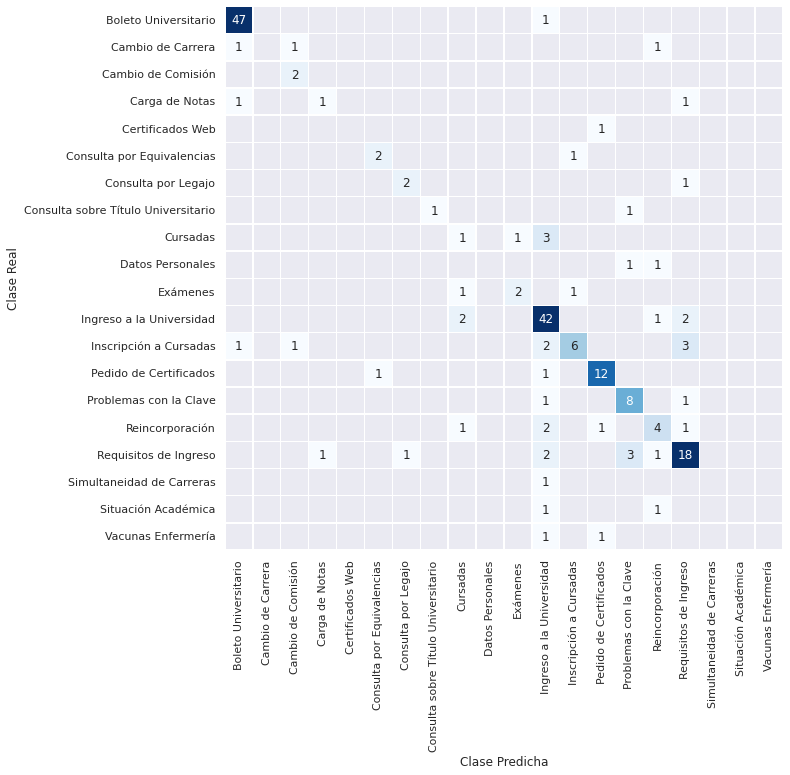

In [10]:
import numpy as np
from sklearn import metrics #Importar el módulo metrics de scikit-learn
import seaborn as sns
import matplotlib.pyplot as plt

matriz_confusion = metrics.confusion_matrix(y_test, y_pred)

sns.set()
my_mask = np.zeros((matriz_confusion.shape[0], matriz_confusion.shape[0]), dtype=int)
for i in range(matriz_confusion.shape[0]):
    for j in range(matriz_confusion.shape[0]):
        my_mask[i][j] = matriz_confusion[i][j] == 0 
  
fig_dims = (10, 10)
plt.subplots(figsize=fig_dims)

ax = sns.heatmap(matriz_confusion,
                 xticklabels=etiquetas,
                 annot=True, 
                 fmt="d", 
                 linewidths=.5, 
                 cmap="Blues", 
                 cbar=False, 
                 mask=my_mask, 
                 vmax=15)

plt.gcf().set_size_inches(10, 10)
plt.xticks(rotation=90, ha="center")
plt.yticks(np.arange(len(etiquetas))+0.5, etiquetas, rotation='horizontal')

plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real');

plt.show()

# Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05